# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import src.util as utils

# Load Config

In [2]:
config = utils.load_config()

# Load Data

In [3]:
# load X_train and y_train
X_train = utils.pickle_load(config['train_set_path'][0])
y_train = utils.pickle_load(config['train_set_path'][1])

In [4]:
# check point (check shape)
print(X_train.shape)
print(y_train.shape)

(700, 3)
(700,)


In [5]:
# concat the data train
train_set = pd.concat([X_train, y_train], axis=1)
train_set.head(10)

,amount,merchant_type,device_type,label
308,158.57,others,mobile,0
628,3.74,clothing,tablet,0
362,61.30,electronics,mobile,0
775,16.24,travel,tablet,0
276,160.09,travel,tablet,0
427,218.66,electronics,mobile,0
556,14.39,travel,desktop,0
498,366.50,others,tablet,0
242,246.35,clothing,tablet,0
286,62.66,groceries,mobile,0


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 308 to 29
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         700 non-null    float64
 1   merchant_type  700 non-null    object 
 2   device_type    700 non-null    object 
 3   label          700 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 27.3+ KB


# Check Value and Statistic Descriptve

In [7]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,700.0,96.337557,93.403048,0.51,28.105,68.595,135.56,569.49
label,700.0,0.050000,0.218101,0.00,0.000,0.000,0.00,1.00


In [9]:
train_set.describe(include='object').T

,count,unique,top,freq
merchant_type,700,5,clothing,148
device_type,700,3,tablet,241


Based on the result:
* The column `amount` may have a skewed distribution because the gap between mean and median is quite large (affected by outliers).
* The categorical feature has 3 and 5 uniqueness, so label encoding may not be appropriate. OHE, mean encoding, freq encoding, and others are the best options so far.
* We'll look at this more in `data_preprocessing`.

# Label Distribution

In [10]:
# check the percentage of label/target
train_set.label.value_counts(normalize=True)

label
0    0.95
1    0.05
Name: proportion, dtype: float64

The imbalance in data fraud is natural for business. The cases that are not fraud are more than fraud. On the other hand, this can be a problem (it is hard) for modeling to generate **generalization** (no overfit and no bias).

We'll do experiment on this data, also the data after handling the unbalanced data, like SMOTE, oversampling, etc.

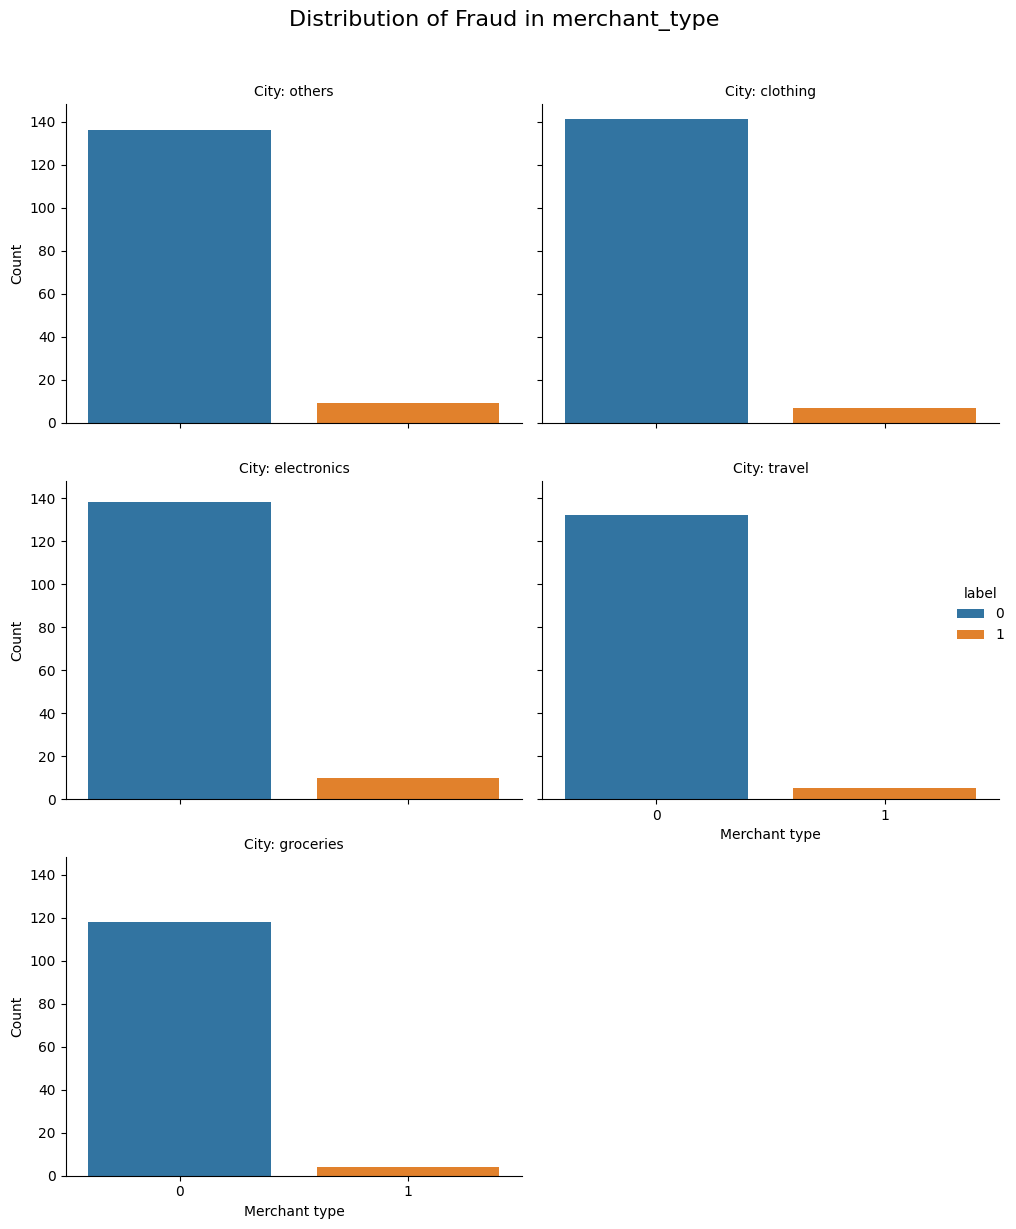

In [11]:
# visualize detection fraud based on merchant_type
ax = sns.catplot(data=train_set, x='label', col='merchant_type', kind='count',
                 hue='label', 
                 col_wrap=2, height=4, aspect=1.2)

ax.set_axis_labels("Merchant type", "Count")
ax.set_titles("City: {col_name}")
plt.suptitle('Distribution of Fraud in merchant_type', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

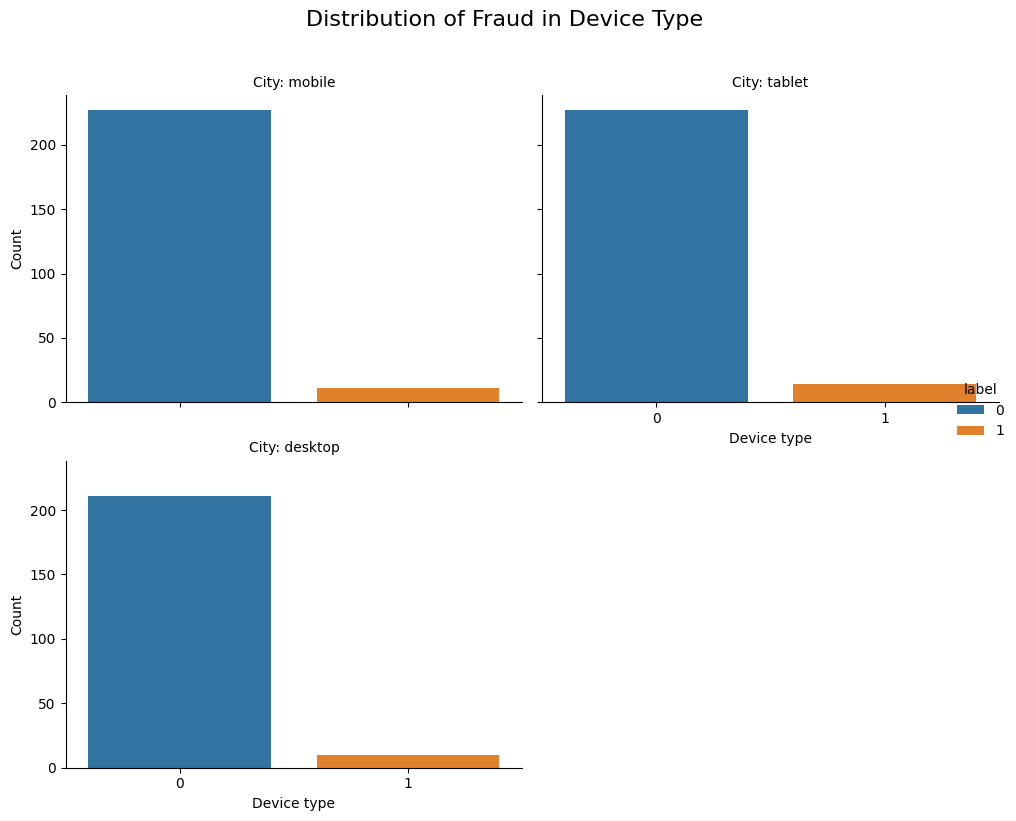

In [12]:
# visualize detection fraud based on device_type
ax = sns.catplot(data=train_set, x='label', col='device_type', kind='count',
                 hue='label', 
                 col_wrap=2, height=4, aspect=1.2)

ax.set_axis_labels("Device type", "Count")
ax.set_titles("City: {col_name}")
plt.suptitle('Distribution of Fraud in Device Type', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Feature Distribution

<Axes: xlabel='amount'>

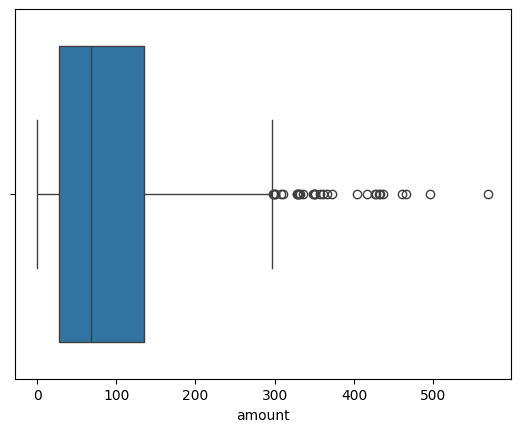

In [15]:
# check box plot in one of features
sns.boxplot(x='amount', data=train_set)

<Axes: xlabel='amount'>

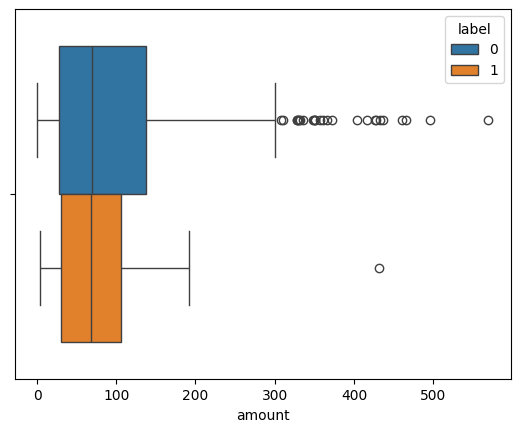

In [16]:
# check box plot in amount by laebl
sns.boxplot(x='amount', data=train_set, hue='label') 

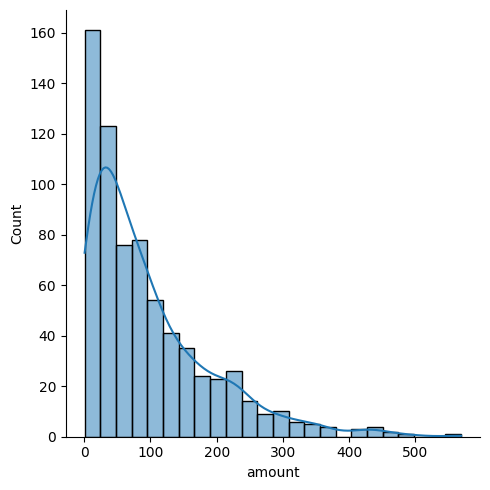

In [17]:
# check distirbution plot in one of features
sns.displot(data=train_set, x='amount', kde=True)

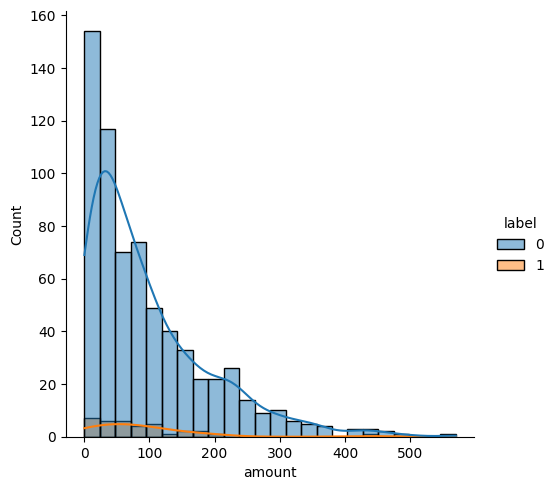

In [18]:
# check distirbution plot in amount by label
sns.displot(data=train_set, x='amount', kde=True, hue='label')

Data may be the problem, whether the model chosen. the reason:
* the features is limited, so the target/label will be captured by chance, not by pattern
* The outlier may also be a problem. We'll use method of handling by transforming rather than removing by IQR because the size of data is already small.
* We'll use this insight for the `data_preprocessing` process.

# Check Correlation Plot

In [21]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 308 to 29
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         700 non-null    float64
 1   merchant_type  700 non-null    object 
 2   device_type    700 non-null    object 
 3   label          700 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 43.5+ KB


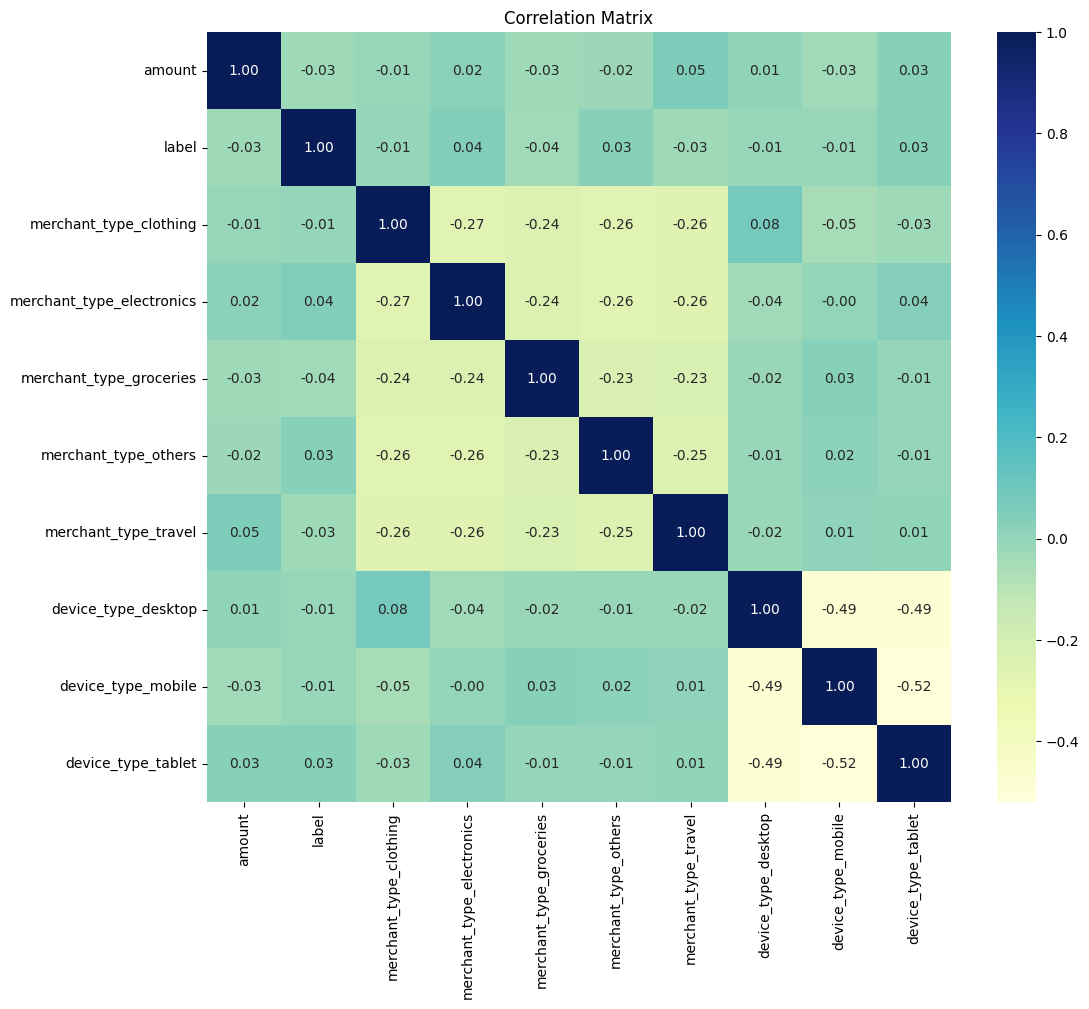

In [22]:
# define categorical col
categorical_cols = train_set.select_dtypes(include='object').columns.tolist()

# OHE
train_set_encoded = pd.get_dummies(train_set, columns=categorical_cols)

# creat corr matrix
corr_matrix = train_set_encoded.corr()

# create visualize with heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The insight of this visualization are:
- there is no pattern that might be a problem in modeling.
- high correlation (low to moderate) is indeed predicted in the encoded features if `drop=‘first’` is not used. Even without this, multicollinearity characterized by high correlations (typically >0.7) is also not found.
- the model non-linear is probably better than linear model, but we'll do this on the `data_modelling` step